# Monte Carlo and Option Pricing 

* Written for the RSE QuantEcon Workshop (February 2023)
* Author: [John Stachurski](http://johnstachurski.net/)

We discuss [Monte Carlo
methods](https://en.wikipedia.org/wiki/Monte_Carlo_method) for computing
expectations with applications in finance.

Our main application will be pricing a European option.

We will show that Monte Carlo is particularly helpful when the distribution of
interest has no neat analytical form.

We will also touch on some high performance computing topics, including 

* just-in-time compilers 
* GPUs and 
* parallelization.

We begin with the following imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numpy.random import randn

## An Introduction to Monte Carlo

In this section we describe the Monte Carlo method of integration via a simple
example.

### Share Price with Known Distribution

Let's suppose that we are considering buying a share (or many shares) in a
given company.

Our plan is either to 

* buy it now, hold it for one year and then sell it, or
* do something else with our money.

We start by thinking of the share price in one year as a random variable $S$.

(Let's forget about dividends for now, so that our return on holding the share
is the relative change in its price.)

To decide whether or not to go ahead, we need to know some features of the
distribution of $S$.

For example, we might decide to buy if the mean is high and the variance is
low.

(High expected returns and low risk.)

Suppose that, after analyzing the data, we have decided that $S$ is well
represented by a lognormal distribution with parameters $\mu, \sigma$ .

* $S$ has the same distribution as $\exp(\mu + \sigma Z)$ where $Z$ is standard normal.
* we write this statement as $S \sim LN(\mu, \sigma)$.

Any good reference on statistics will tell us that the mean and variance are

$$
    \mathbb E S 
        = \exp \left(\mu + \frac{\sigma^2}{2} \right)
$$

and 

$$ 
    \mathop{\mathrm{Var}} S 
    = [\exp(\sigma^2) - 1] \exp(2\mu + \sigma^2)
$$

So far we have no need for a computer.

### Share Price with Unknown Distribution

But now suppose that we study the distribution of $S$ more carefully, leading
us to decompose the price into multiple factors.

In particular, we conclude that the share price depends on three variables,
with

$$
    S = (X_1 + X_2 + X_3)^p
$$

We assume that

* $p$ is a positive number, which is known to us,
* $X_i \sim LN(\mu_i, \sigma_i)$ for $i=1,2,3$,
* the values of $\mu_i, \sigma_i$ have all been estimated, and
* the random variables $X_1$, $X_2$ and $X_3$ are independent.

How should we compute the mean of $S$?

To do this with pencil and paper is hard (unless, say, $p=1$).

But fortunately there's an easy way to do this, at least approximately:

1. Generate $n$ independent draws of $X_1$, $X_2$ and $X_3$ on a computer,
1. Use these draws to generate $n$ independent draws of $S$, and
1. Take the average value of these draws of $S$.

By the law of large numbers, this average will be close to the true mean when
$n$ is large.

We use the following values for $p$ and each $\mu_i$ and $\sigma_i$.

In [2]:
p = 0.5
μ_1, μ_2, μ_3 = 0.2, 0.8, 0.4
σ_1, σ_2, σ_3 = 0.1, 0.05, 0.2

Our default simulation size will be

In [3]:
n = 10_000_000

#### A Routine using Loops in Python

Here's a routine using native Python loops to calculate the desired mean

$$
    \frac{1}{n} \sum_{i=1}^n S_i
    \approx \mathbb E S
$$

In [4]:
%%time

S = 0.0
for i in range(n):
    X_1 = np.exp(μ_1 + σ_1 * randn())
    X_2 = np.exp(μ_2 + σ_2 * randn())
    X_3 = np.exp(μ_3 + σ_3 * randn())
    S += (X_1 + X_2 + X_3)**p
S / n

CPU times: user 53.5 s, sys: 256 ms, total: 53.7 s
Wall time: 1min


2.2296824880581068

Let's construct a function that contains these operations:

In [5]:
def compute_mean(n=10_000_000):
    S = 0.0
    for i in range(n):
        X_1 = np.exp(μ_1 + σ_1 * randn())
        X_2 = np.exp(μ_2 + σ_2 * randn())
        X_3 = np.exp(μ_3 + σ_3 * randn())
        S += (X_1 + X_2 + X_3)**p
    return(S / n)

In [6]:
compute_mean()

2.2297086815493574

#### Using Numba's JIT Compiler

In [7]:
compute_mean_numba = numba.jit(compute_mean)

In [8]:
%%time

compute_mean_numba()

CPU times: user 2.19 s, sys: 144 ms, total: 2.33 s
Wall time: 2.27 s


2.2296810209118942

In [9]:
%%time

compute_mean_numba()

CPU times: user 1.85 s, sys: 1.96 ms, total: 1.85 s
Wall time: 1.9 s


2.2297533743020925

#### A Vectorized Routine

Now we implement a vectorized routine using traditional NumPy array processing.

In [10]:
def compute_mean_vectorized(n=10_000_000):
    X_1 = np.exp(μ_1 + σ_1 * randn(n))
    X_2 = np.exp(μ_2 + σ_2 * randn(n))
    X_3 = np.exp(μ_3 + σ_3 * randn(n))
    S = (X_1 + X_2 + X_3)**p
    return(S.mean())

In [11]:
%%time

compute_mean_vectorized()

CPU times: user 1.3 s, sys: 107 ms, total: 1.41 s
Wall time: 1.43 s


2.2297789083934867

#### Using Google JAX

Finally, let's try to shift this to the GPU (if you have one) and parallelize it effectively.

In [12]:
import jax
import jax.numpy as jnp

In [13]:
!nvidia-smi

Tue Apr 25 04:07:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
def compute_mean_jax(n=10_000_000):
    key = jax.random.PRNGKey(1)
    Z = jax.random.normal(key, (3, n))
    X_1 = jnp.exp(μ_1 + σ_1 * Z[0,:])
    X_2 = jnp.exp(μ_2 + σ_2 * Z[1,:])
    X_3 = jnp.exp(μ_3 + σ_3 * Z[2,:])
    S = (X_1 + X_2 + X_3)**p
    return(S.mean())

In [15]:
%%time

compute_mean_jax()

CPU times: user 1.45 s, sys: 872 ms, total: 2.32 s
Wall time: 6.36 s


Array(2.2297425, dtype=float32)

In [16]:
compute_mean_jax_jitted = jax.jit(compute_mean_jax)

In [17]:
%%time

compute_mean_jax_jitted()

CPU times: user 440 ms, sys: 5.11 ms, total: 445 ms
Wall time: 602 ms


Array(2.2297425, dtype=float32)

In [18]:
%%time

compute_mean_jax_jitted()

CPU times: user 643 µs, sys: 0 ns, total: 643 µs
Wall time: 497 µs


Array(2.2297425, dtype=float32)

## Pricing a European Call Option under Risk Neutrality

As our next step, we are going to price a European call option under risk
neutrality.

Let's first discuss risk neutrality and then introduce European options.

### Risk-Neutral Pricing

When we use risk-neutral pricing, we determine the price of a given asset
according to its expected payoff.

$$
\text{cost } = \text{ expected benefit}
$$

For example, suppose someone promises to pay you

- 1,000,000 dollars if "heads" is the outcome of a fair coin flip
- 0 dollars if "tails" is the outcome

Let's denote the payoff as $G$, so that 

$$
    \mathbb P\left\{G = 10^6 \right\} = \mathbb P\{G = 0\} = \frac{1}{2}
$$

Suppose in addition that you can sell this promise to anyone who wants to
hold it 

- First they pay you $P$, the price at which you sell it
- Then they get $G$, which could be either 1,000,000 or 0.

What's a fair price for this asset (this promise)?

The definition of fair is ambiguous but what we can say is that the
risk-neutral price is 500,000 dollars.

This is because the risk-neutral price is just the expected payoff of the
asset, which is

$$
    \mathbb E G = \frac{1}{2} \times 10^6 + \frac{1}{2} \times 0 = 5 \times 10^5
$$

### A Comment on Risk

As suggested by the name, the risk-neutral price ignores risk.

To understand this, consider whether you would pay 500,000 dollars for such a
promise.

Would you prefer to receive 500,000 for sure or 1,000,000 dollars with
50% probability and nothing with 50% probability?

At least some readers will strictly prefer the first option --- although some
might prefer the second.

Thinking about this makes us realize that 500,000 is not necessarily the
"right" price --- or the price that we would see if there was a market for
these promises.

Nonetheless, the risk-neutral price is an important benchmark, which economists
and financial market participants routinely try to calculate.

### Discounting

One thing we ignored in the previous discussion was time.

In general, receiving $x$ dollars now is preferable to receiving $x$ dollars
in $n$ periods (e.g., 10 years).

After all, if we receive $x$ dollars now, we could put it in the bank at
interest rate $r > 0$ and receive $ (1 + r)^n x $ in $n$ periods.

Hence future payments need to be discounted.

We will implement discounting by 

* multiplying a payment in one period by $\beta < 1$
* multiplying a payment in $n$ periods by $\beta^n$, etc.

The same adjustment needs to be applied to our risk-neutral price for the
promise described above.

Thus, if $G$ is realized in $n$ periods, then the risk-neutral price is

$$
    P = \beta^n \mathbb E G 
      = \beta^n 5 \times 10^5
$$

### European Call Options

Now let's price a European call option.

The option is described by three things:

2. $n$, the **expiry date**,
2. $K$, the **strike price**, and
3. $S_n$, the price of the **underlying** asset at date $n$.

For example, suppose that the underlying is one share in Amazon.

The owner of this option has the right to buy one share in Amazon at price $K$ after $n$ days.

If $S_n > K$, then the owner will exercise the option, buy at $K$, sell at
$S_n$, and make profit $S_n - K$.

If $S_n \leq K$, then the owner will not exercise the option and the payoff is zero.

Thus, the payoff is $\max\{ S_n - K, 0 \}$.

Under the assumption of risk neutrality,  the price of the option is 
the expected discounted payoff:

$$ P = \beta^n \mathbb E \max\{ S_n - K, 0 \} $$

Now all we need to do is specify the distribution of $S_n$, so the expectation
can be calculated.

**Exercise**

Suppose we know that $S_n \sim LN(\mu, \sigma)$ and $\mu$ and $\sigma$ are known.

Use the fact that if $S_n^1, \ldots, S_n^M$ are independent draws from this lognormal distribution then, by the law of large numbers,

$$ \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
    $$

Use the following parameter values:

In [19]:
μ = 1.0
σ = 0.1

In [20]:
K = 1
n = 10
β = 0.95

Set the simulation size to

In [21]:
M = 10_000_000

In [22]:
# Put your code here

In [23]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [24]:
S = np.exp(μ + σ * np.random.randn(M))
return_draws = np.maximum(S - K, 0)
P = β**n * np.mean(return_draws) 
print(f"The Monte Carlo option price is {P:3f}")

The Monte Carlo option price is 1.036906


## Pricing Via a Dynamic Model

In this exercise we investigate a more realistic model for the share price $S_n$.

This comes from specifying the underlying dynamics of the share price.

First we specify the dynamics.

Then we'll compute the price of the option using Monte Carlo.

### Simple Dynamics

One simple model for $\{S_t\}$ is

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma \xi_{t+1} $$

where 

* $S_0$ is normally distributed and
* $\{ \xi_t \}$ is IID and standard normal.  


**Exercise**

Show that, under the stated assumptions, $S_n$ is lognormally distributed.

In [25]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


With $s_t := \ln S_t$, the price dynamics become

$$ s_{t+1} = s_t + \mu + \sigma \xi_{t+1} $$

Since $s_0$ is normal and $\xi_1$ is normal and IID, we see that $s_1$ is
normally distributed.

Continuing in this way shows that $s_n$ is normally distributed.

Hence $S_n = \exp(s_n)$ is lognormal.


### Problems with Simple Dynamics

The simple dynamic model we studied above is convenient, since we can work out
the distribution of $S_n$.


However, its predictions are counterfactual because, in the real world,
volatility (measured by $\sigma$) is not stationary.

Instead it rather changes over time, sometimes high (like during the GFC) and sometimes low.


### More Realistic Dynamics

As stated above, one problem with our simple model is that $\sigma$ is
constant.

This leads us to study the improved version:

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1} $$

where 

$$ 
    \sigma_t = \exp(h_t), 
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

Here $\{\eta_t\}$ is also IID and standard normal.

### Default Parameters

For the dynamic model, we adopt the following parameter values.

In [26]:
μ  = 0.0001
ρ  = 0.1
ν  = 0.001
S0 = 10
h0 = 0

(Here `S0` is $S_0$ and `h0` is $h_0$.)

For the option we use the following defaults.

In [27]:
K = 100
n = 10
β = 0.95

**Exercise**


Write a function that simulates the sequence $S_0, \ldots, S_n$, where the parameters are set to

Plot 50 paths of the form $S_0, \ldots, S_n$.

In [28]:
# Put your code here

In [29]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


With $s_t := \ln S_t$, the price dynamics become

$$ s_{t+1} = s_t + \mu + \exp(h_t) \xi_{t+1} $$

Here is a function to simulate a path using this equation:

In [30]:
from numpy.random import randn

def simulate_asset_price_path(μ=μ, S0=S0, h0=h0, n=n, ρ=ρ, ν=ν):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()
        
    return np.exp(s)

Here we plot the paths and the log of the paths.

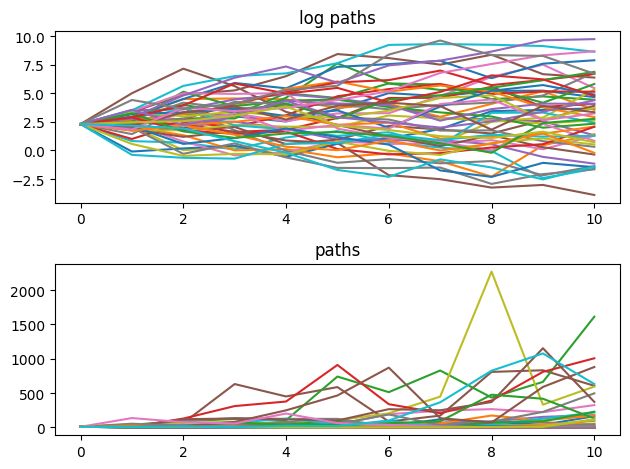

In [31]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path()
        ax.plot(transform(path))
    ax.set_title(title)
    
fig.tight_layout()
plt.show()

**Exercise**

Compute the price of the option $P_0$ by Monte Carlo, averaging over realizations $S_n^1, \ldots, S_n^M$ of $S_n$ and appealing to the law of large numbers:

$$ \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
    $$
    

To the extend that you can, write fast, efficient code to compute the option price.  

In particular, try to speed up the code above using `jit` or `njit` from Numba.

In [32]:
# Put your code here

In [33]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [34]:
from numba import njit, prange

In [35]:
@njit
def compute_call_price(β=β,
                       μ=μ,
                       S0=S0,
                       h0=h0,
                       K=K,
                       n=n,
                       ρ=ρ,
                       ν=ν,
                       M=10_000_000):
    current_sum = 0.0
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

In [36]:
%%time 
compute_call_price()

CPU times: user 7.98 s, sys: 28.2 ms, total: 8.01 s
Wall time: 8.06 s


850.1075361413203

**Exercise**

If you can, use `prange` from Numba to parallelize this code and make it even faster.

In [37]:
# Put your code here

In [38]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [39]:
@njit(parallel=True)
def compute_call_price_parallel(β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=10_000_000):
    current_sum = 0.0
    # For each sample path
    for m in prange(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

In [40]:
from numba import get_num_threads, set_num_threads
get_num_threads()

2

In [41]:
%%time
compute_call_price_parallel()

CPU times: user 11 s, sys: 25.6 ms, total: 11 s
Wall time: 7.27 s


867.3796934392012

In [42]:
%%time
compute_call_price_parallel()

CPU times: user 10.2 s, sys: 8.2 ms, total: 10.2 s
Wall time: 5.32 s


867.9281455018007

## Pricing a European Call Option Using JAX

Previously we computed the value of a European call option via Monte Carlo using Numba-based routines.

Let's compare how this looks, and how fast it runs, when we implement using [Google JAX](https://python-programming.quantecon.org/jax_intro.html).

**Exercise**

Try to shift the whole operation to the GPU using JAX and test your speed gain.

In [43]:
# Put your code here

In [44]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [45]:
!nvidia-smi

Tue Apr 25 04:08:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |  11729MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
import jax
import jax.numpy as jnp

In [47]:
@jax.jit
def compute_call_price_jax(β=β,
                           μ=μ,
                           S0=S0,
                           h0=h0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=10_000_000,
                           key=jax.random.PRNGKey(1)):

    s = jnp.full(M, np.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))
        
    return β**n * expectation

In [48]:
%%time 
compute_call_price_jax().block_until_ready()

CPU times: user 1.52 s, sys: 45 ms, total: 1.57 s
Wall time: 2.72 s


Array(839.4134, dtype=float32)

In [49]:
%%time 
compute_call_price_jax().block_until_ready()

CPU times: user 1.73 ms, sys: 28 µs, total: 1.76 ms
Wall time: 34.5 ms


Array(839.4134, dtype=float32)